# RynnBrain Inference Recipes

## Section 2: Object Understanding
In this section, we present the ability for RynnBrain in egocentric understanding, including `fine-grained object understanding` and `counting`.

In setting, user can specify the object they inserest by either text or visual prompt.

### [Setup] Load visualization utils

In [1]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)

import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sample_video_frames_and_show(
    video_path,
    num_samples=32,
    cols=8,
    figsize_per_cell=1.2,  
    title="index",
    downscale=2          
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Can not open video: {video_path}")

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, n_frames - 1, num_samples).round().astype(int)

    frames = []
    valid_idxs = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame_bgr = cap.read()
        if not ok:
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        if downscale is not None and downscale > 1:
            h, w = frame_rgb.shape[:2]
            new_size = (w // downscale, h // downscale)
            frame_rgb = cv2.resize(frame_rgb, new_size, interpolation=cv2.INTER_AREA)

        frames.append(frame_rgb)
        valid_idxs.append(idx)

    cap.release()

    cols = min(cols, len(frames)) if len(frames) > 0 else cols
    rows = int(np.ceil(len(frames) / cols)) if len(frames) > 0 else 1
    plt.figure(figsize=(cols * figsize_per_cell, rows * figsize_per_cell))
    for i, img in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        if title == "index":
            ax.set_title(f"{i}", fontsize=8)
        elif title == "frame_idx":
            ax.set_title(f"{valid_idxs[i]}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def add_frame_id(conversation):
  for message in conversation:
    if message["role"] == "user":
        image_idx = 0
        new_contents = []
        for i, content in enumerate(message["content"]):
            if content["type"] == "image":
                    new_contents.append({"type": "text", "text": f"<frame {image_idx}>: "})
                    image_idx += 1
            new_contents.append(content)
        message["content"] = new_contents
  return conversation


def show_images_grid(
    img_dir,
    n=8,
    cols=4,
    figsize_per_cell=(4, 4),
    exts=("png", "jpg", "jpeg", "bmp", "webp"),
    sort=True,
    show_title=True,
    keep_axis=True,
):
    patterns = [os.path.join(img_dir, f"*.{e}") for e in exts]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    if sort:
        paths = sorted(paths)

    paths = paths[:n]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {exts}")

    rows = (len(paths) + cols - 1) // cols
    fig_w = figsize_per_cell[0] * cols
    fig_h = figsize_per_cell[1] * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            p = paths[i]
            img = Image.open(p)
            ax.imshow(img)

            if show_title:
                ax.set_title(os.path.basename(p), fontsize=10)

            if keep_axis:
                ax.tick_params(labelsize=8)
            else:
                ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def convert_bbox(bbox, w, h):
    x1, y1, x2, y2 = bbox_raw
    bbox_norm = [
        int(round(x1 / (w-1) * 1000)),
        int(round(y1 / (h-1) * 1000)),
        int(round(x2 / (w-1) * 1000)),
        int(round(y2 / (h-1) * 1000)),
    ]
    bbox_norm = [max(0, min(1000, v)) for v in bbox_norm]
    return f"({bbox_norm[0]}, {bbox_norm[1]}), ({bbox_norm[2]}, {bbox_norm[3]})"

def draw_bbox_on_image(img_path, bbox, color="red", width=4, show_width=400):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    x1, y1, x2, y2 = bbox
    draw.rectangle([x1, y1, x2, y2], outline=color, width=width)

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=show_width))

### [General] Load Model and Processor

In [2]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "Alibaba-DAMO-Academy/RynnBrain-8B"
model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)


/usr/local/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


### Example1: Fine-grained Object Understanding

1.Load and visualize the video

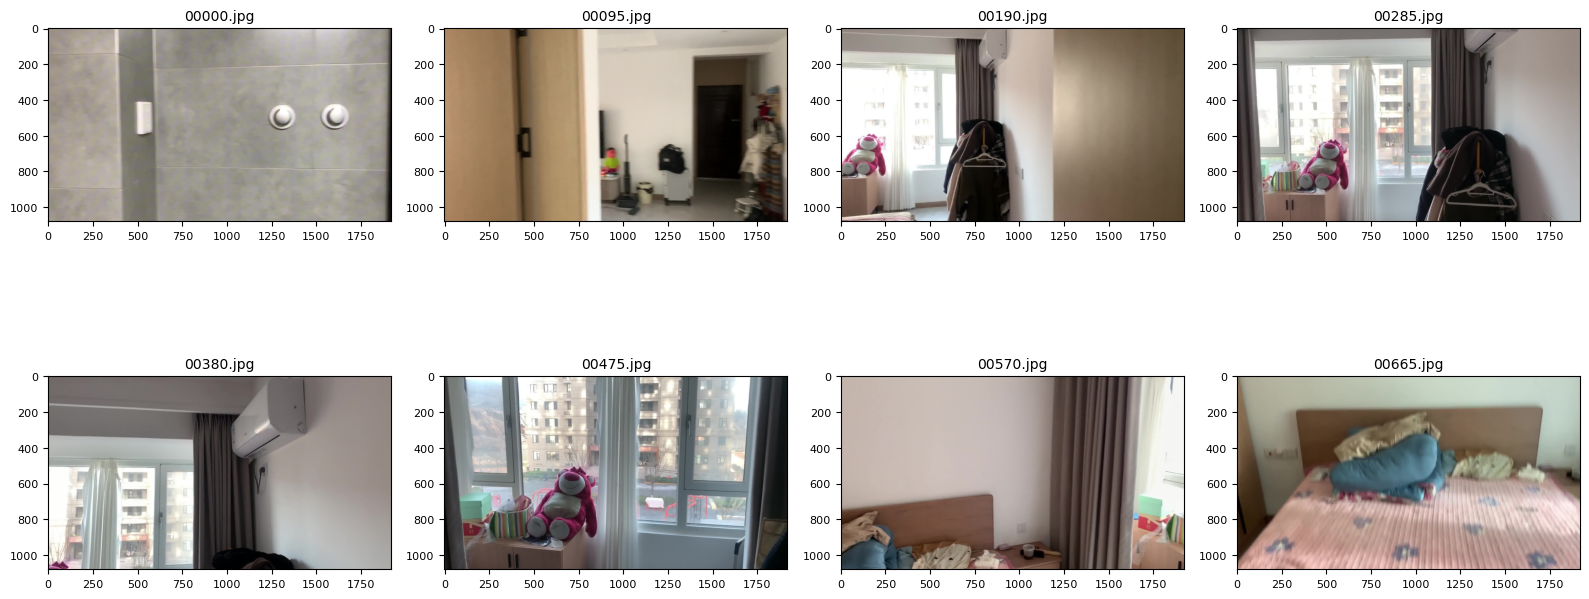

In [3]:
VIDEO_PATH="assets/object_understanding/0"
show_images_grid(VIDEO_PATH)

**[via text prompt]**

2.generate messages and infer with RynnBrain

In [4]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

content.append({"type": "text", "text": f"What color is the bedsheet?"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
print(messages)

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print('Answer: ', output_text)


[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/object_understanding/0/00000.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00095.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00190.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00285.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00380.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00475.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00570.jpg'}, {'type': 'image', 'image': 'assets/object_understanding/0/00665.jpg'}, {'type': 'text', 'text': 'What color is the bedsheet?'}]}]
Answer:  pink


**[via visual prompt]**

2.Select bbox and generate messages

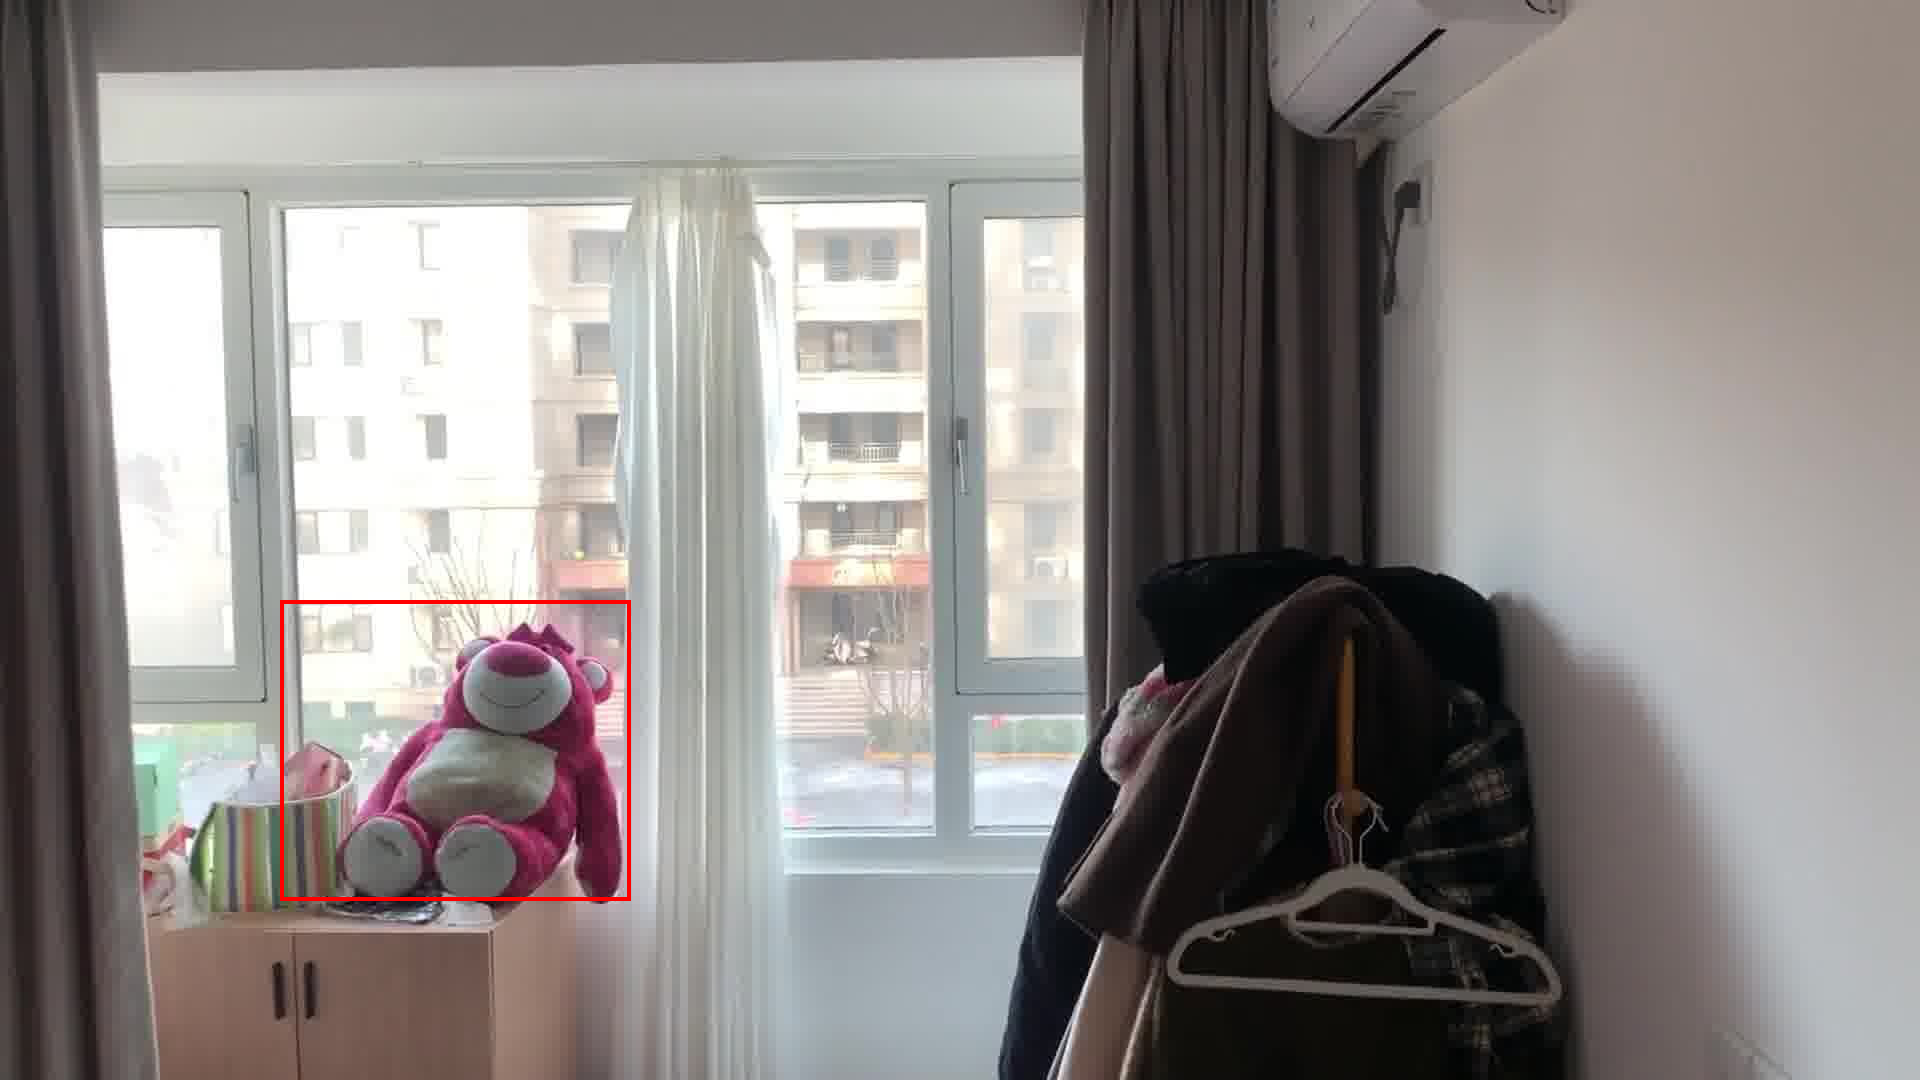

[{'role': 'user', 'content': [{'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00000.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00095.jpg'}, {'type': 'text', 'text': '<frame 2>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00190.jpg'}, {'type': 'text', 'text': '<frame 3>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00285.jpg'}, {'type': 'text', 'text': '<frame 4>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00380.jpg'}, {'type': 'text', 'text': '<frame 5>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00475.jpg'}, {'type': 'text', 'text': '<frame 6>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00570.jpg'}, {'type': 'text', 'text': '<frame 7>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00665.jpg'}, {'type': 'text', 'text': 'Wht is the function of <object> <frame3>; (146, 

In [5]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

w, h = Image.open(img_paths[0]).size

bbox_raw = [280, 600, 630, 900]
frame_idx = 3
draw_bbox_on_image(img_paths[frame_idx], bbox_raw)

bbox_str = convert_bbox(bbox_raw, w, h)

content.append({"type": "text", "text": f"What is the function of <object> <frame{frame_idx}>; {bbox_str} </object>?"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
messages = add_frame_id(messages)
print(messages)

3.Infer with RynnBrain

In [6]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

The object serves as a decorative item or a toy for comfort and play.


### Example2: Counting


**[via text prompt]**

1.Load and visualize the video


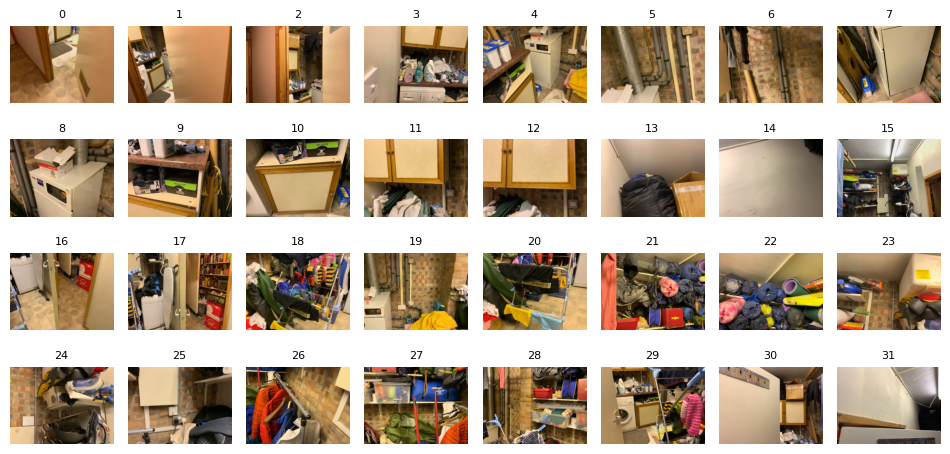

In [7]:
VIDEO_PATH2 = './assets/object_understanding/44358451.mp4'
sample_video_frames_and_show(VIDEO_PATH2)

2.Generaet messages and infer with RynnBrain

In [8]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": VIDEO_PATH2,
            },
            {"type": "text", "text": "How many washer(s) are in this room?"},
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

2


**[via visual prompt]**


2.Select bbox and generate messages



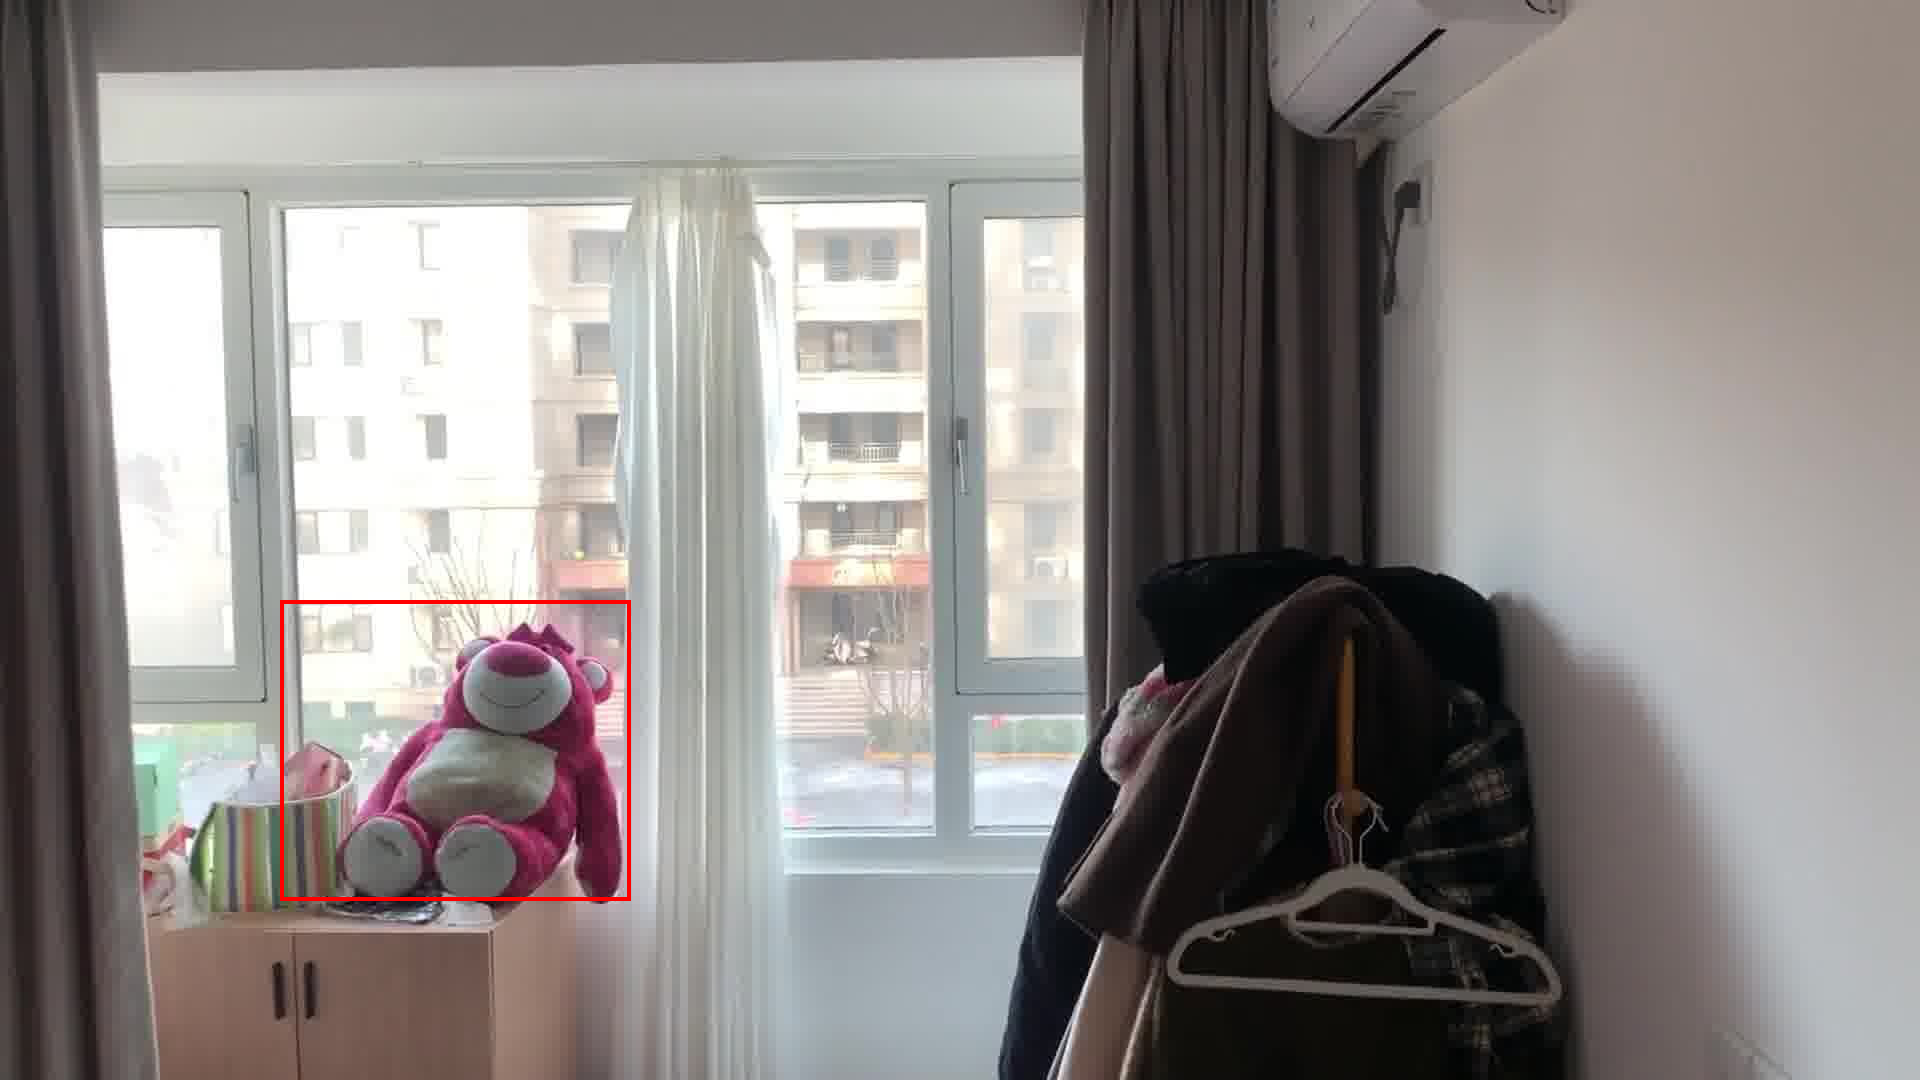

[{'role': 'user', 'content': [{'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00000.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00095.jpg'}, {'type': 'text', 'text': '<frame 2>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00190.jpg'}, {'type': 'text', 'text': '<frame 3>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00285.jpg'}, {'type': 'text', 'text': '<frame 4>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00380.jpg'}, {'type': 'text', 'text': '<frame 5>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00475.jpg'}, {'type': 'text', 'text': '<frame 6>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00570.jpg'}, {'type': 'text', 'text': '<frame 7>: '}, {'type': 'image', 'image': 'assets/object_understanding/0/00665.jpg'}, {'type': 'text', 'text': 'How many handles are under <object> <frame3>; (1

In [9]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

w, h = Image.open(img_paths[0]).size

bbox_raw = [280, 600, 630, 900]
frame_idx = 3
draw_bbox_on_image(img_paths[frame_idx], bbox_raw)

bbox_str = convert_bbox(bbox_raw, w, h)

content.append({"type": "text", "text": f"How many handles are under <object> <frame{frame_idx}>; {bbox_str} </object>?"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
messages = add_frame_id(messages)
print(messages)

2